The following are the results we've got from online augmentation so far. Some bugs have been fixed by Scott since then so these might be redundant. If they're not redundant then they are __very bad__.

Loading the pickle
======

In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [9]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/replicate_8aug.json", settings, force=True)

In [10]:
model = pylearn2.utils.serial.load(run_settings['alt_picklepath'])

In [11]:
c = 'train_objective'
channel = model.monitor.channels[c]

Replicating 8aug
======

The DensePNGDataset run with 8 augmentations got us most of the way to our best score in one go. If we can replicate that results with online augmentation then we can be pretty confident that online augmentation is a good idea. Unfortunately, it looks like we can't:

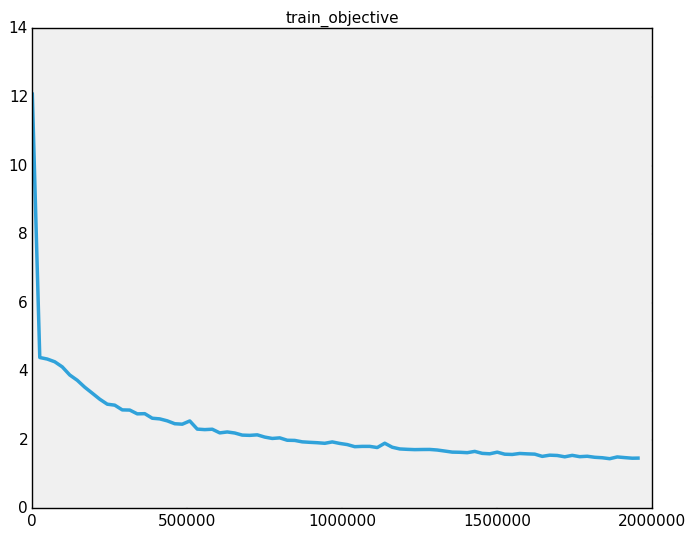

In [12]:
plt.title(c)
plt.plot(channel.example_record,channel.val_record)

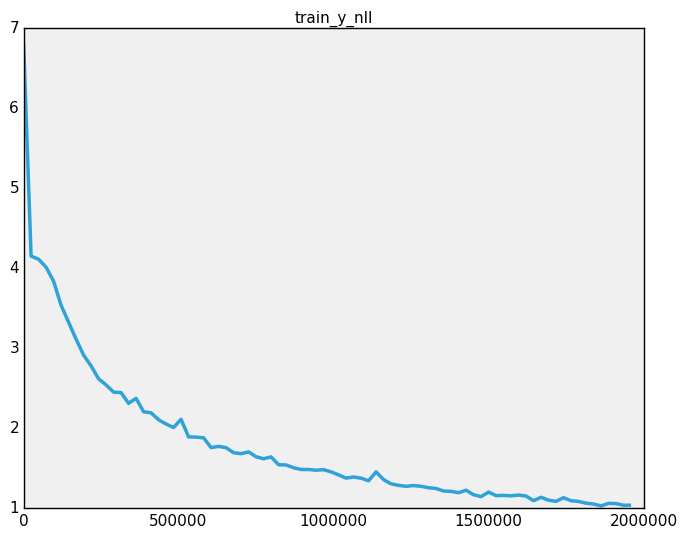

In [13]:
c = 'train_y_nll'
channel = model.monitor.channels[c]
plt.title(c)
plt.plot(channel.example_record,channel.val_record)

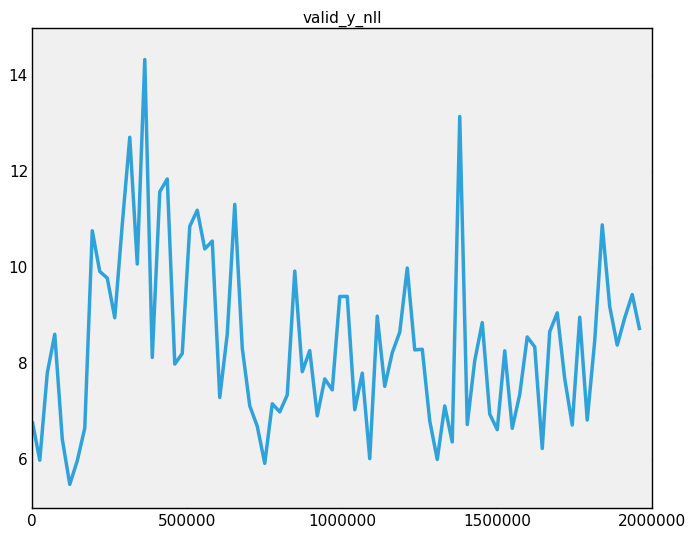

In [14]:
def plot_monitor(c = 'valid_y_nll'):
    channel = model.monitor.channels[c]
    plt.title(c)
    plt.plot(channel.example_record,channel.val_record)
    return None
plot_monitor()

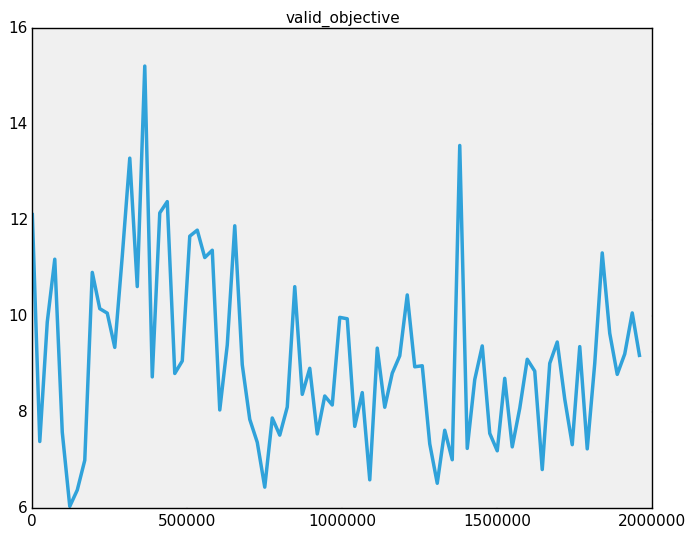

In [15]:
plot_monitor(c="valid_objective")

Would actually like to know what kind of score this model gets on the check_test_score script.

In [33]:
%run check_test_score.py run_settings/replicate_8aug.json

Log loss: 28.8111648568


So we can guess that the log loss score we're seeing is in fact correct. There are definitely some bugs in the ListDataset code.

Many Augmentations
======

We want to be able to use online augmentations to run large combinations of different augmentations on the images. This model had almost everything turned on, a little:

In [16]:
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/online_manyaug.json", settings, force=True)

In [17]:
model = pylearn2.utils.serial.load(run_settings['alt_picklepath'])

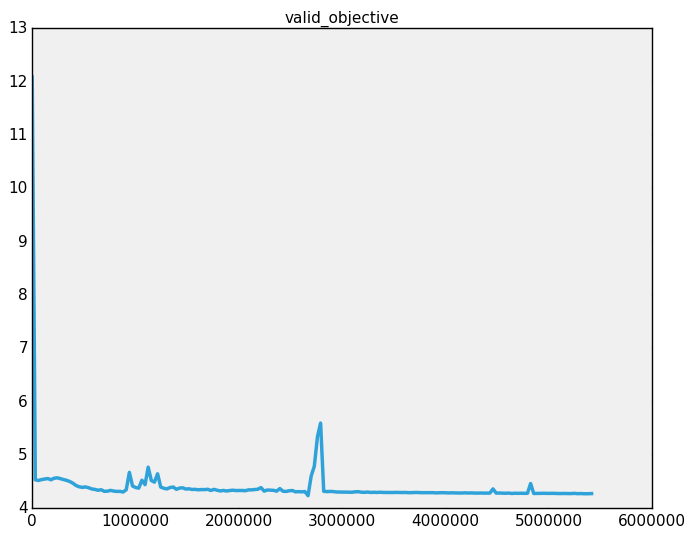

In [18]:
plot_monitor(c="valid_objective")

Looks like it's completely incapable of learning.

These problems suggest that the augmentation might be garbling the images; making them useless for learning from. Or worse, garbling the order so each image doesn't correspond to its label.

Transformer Results
=======

We also have results from a network trained using a `Transformer` dataset, which is how online augmentation is supposed to be supported in Pylearn2.

In [23]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/alexnet_based_onlineaug.json", settings, force=True)

In [24]:
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

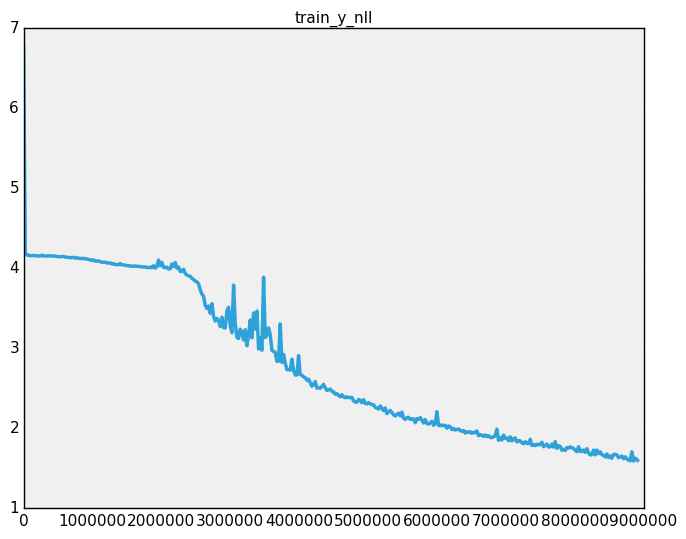

In [25]:
plot_monitor(c="train_y_nll")

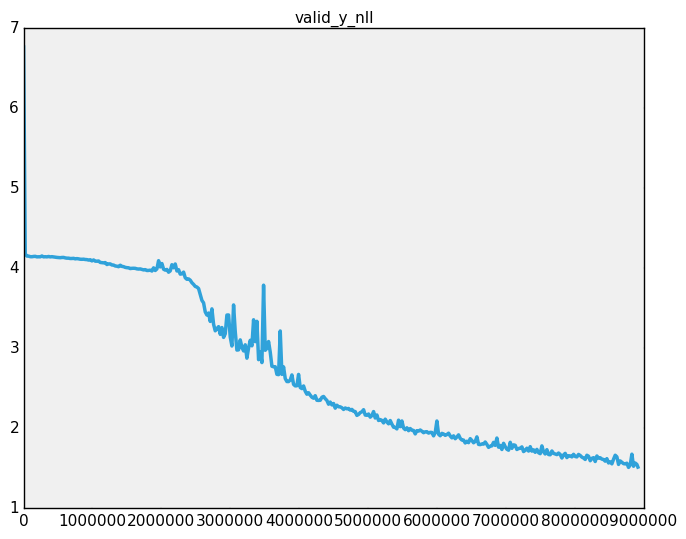

In [26]:
plot_monitor(c="valid_y_nll")

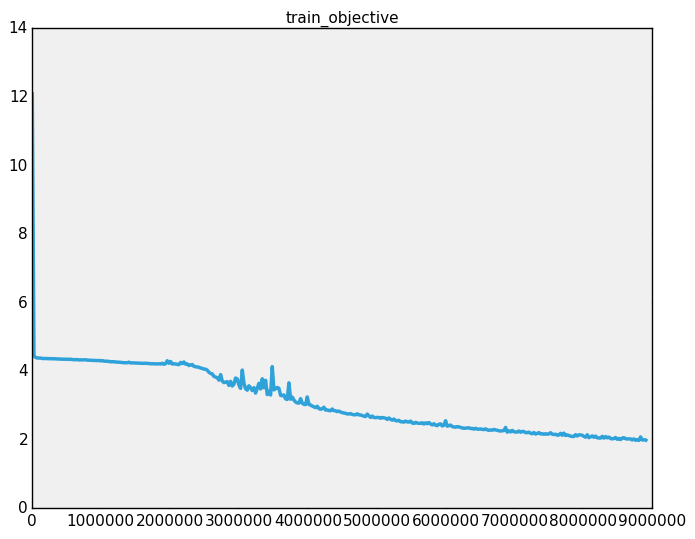

In [27]:
plot_monitor(c="train_objective")

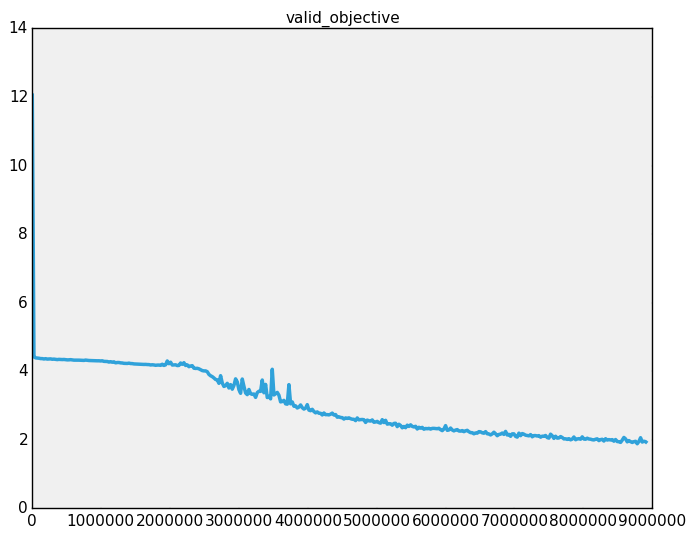

In [28]:
plot_monitor(c="valid_objective")

So not completely broken, but we're not seeing the same results we saw with the 8aug code. There are a couple of reasons this could be the case. Firstly, it's not using normalisation as that code was, and secondly the epochs are much shorter. Also, it's using different augmentations, and it's doing them _after_ resizing.

Making a new YAML to look at this: